In [1]:
!pwd

/home/ubuntu/Notebook


In [2]:
!ls

diabetic-gpu8-train-preprocess-128-512.ipynb  diabetic-test-preprocess.ipynb
diabetic-gpu8-train-preprocess-256.ipynb      diabetic-train-preprocess.ipynb
diabetic-model-gpu.ipynb		      tensoboard_logs
diabetic-model.ipynb			      vgg_dr


In [1]:
import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = ""
import pandas as pd
import numpy as np
# from medpy.io import load
from matplotlib import pyplot as plt
import glob
import cv2
import time

import sklearn.metrics as sklm

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.optimizers import SGD
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model
from keras.callbacks import TensorBoard

import scipy
import matplotlib.image as mpimg
from scipy.misc import imread

%matplotlib inline

Using TensorFlow backend.


In [2]:
Use_Model = "VGGNet" #"ResNet" or "VGGNet"
image_size = 256
num_epochs = 5
# Send 'my_batch_size' number training data at a time to GPU, else GPU runs out of memory if entire x_train and y_train is sent. 
# May have to set it lower than 10 for 512 image size
my_batch_size = 10 

In [3]:
resize_128_dir = "/home/ubuntu/final_data/train/128"
# Create directory for 128x128 resize
try:
    os.stat(resize_128_dir)
except:
    os.makedirs(resize_128_dir)
    
resize_256_dir = "/home/ubuntu/final_data/train/256"
# Create directory for 256x256 resize
try:
    os.stat(resize_256_dir)
except:
    os.makedirs(resize_256_dir)

resize_512_dir = "/home/ubuntu/final_data/train/512"
# Create directory for 512x512 resize
try:
    os.stat(resize_512_dir)
except:
    os.makedirs(resize_512_dir)

In [4]:
# read the labels
labels = pd.read_csv('/home/ubuntu/trainLabels.csv')
labels.head(10)

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
5,15_right,2
6,16_left,4
7,16_right,4
8,17_left,0
9,17_right,1


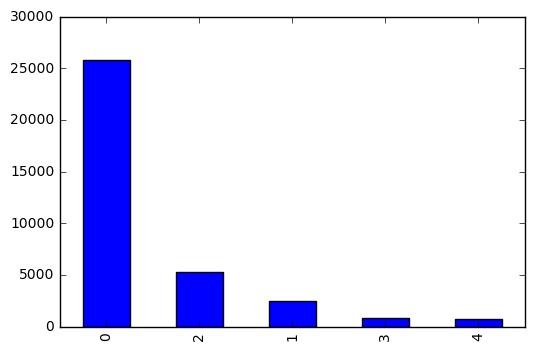

In [5]:
# class imbalance
labels['level'].value_counts().plot(kind='bar')

# Notes:
# 5 labels present - 0 to 4

In [6]:
x_train_list = []
y_train_list = []
x_val_list = []
y_val_list = []

train_percent = 0.6 # 60% train
if image_size == 128:
    Image_File_Path = resize_128_dir
elif image_size == 256:
    Image_File_Path = resize_256_dir
else:
    Image_File_Path = resize_512_dir
        
for index, row in labels.iterrows():
    try:
        img_data = np.fromfile(Image_File_Path + '/' + row['image'] + '.data', dtype='uint8', sep="")
    except:
        continue

    img_data = img_data.reshape([image_size, image_size, 3])
    
    rand_no = np.random.rand()
    if rand_no <= train_percent:
        x_list = x_train_list
        y_list = y_train_list
    else:
        x_list = x_val_list
        y_list = y_val_list
        
    if row['level'] == 0:
        y_list.append([1, 0, 0, 0, 0])
    elif row['level'] == 1:
        y_list.append([0, 1, 0, 0, 0])
    elif row['level'] == 2:
        y_list.append([0, 0, 1, 0, 0])
    elif row['level'] == 3:
        y_list.append([0, 0, 0, 1, 0])
    elif row['level'] == 4:
        y_list.append([0, 0, 0, 0, 1])
    else:
        continue
    
    x_list.append(img_data)

x_train = np.array(x_train_list)
y_train = np.array(y_train_list)

print x_train.shape
print y_train.shape

x_val = np.array(x_val_list)
y_val = np.array(y_val_list)

print x_val.shape
print y_val.shape


(21163, 256, 256, 3)
(21163, 5)
(13963, 256, 256, 3)
(13963, 5)


In [7]:
print y_val

[[1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 ..., 
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]


In [8]:
from sklearn.metrics import confusion_matrix

In [9]:
pd.DataFrame(np.argmax(y_val, axis=1)).loc[:, 0].value_counts() / y_val.shape[0]

0    0.734584
2    0.152188
1    0.068323
3    0.025209
4    0.019695
Name: 0, dtype: float64

In [10]:
# Function for VGGNet
def VGGNet_model(input_shape, num_classes, use_sgd=False, train_bottom=False):
    model_vgg19_conv = VGG19(weights='imagenet', include_top=False)
    model_vgg19_conv.summary()
    
    if not train_bottom: 
        for layer in model_vgg19_conv.layers:
            layer.trainable = False

    # Create your own input format
    input = Input(shape=input_shape, name = 'image_input')
    
    # Use the generated model 
    output_vgg19_conv = model_vgg19_conv(input)
  
    
    # Add the fully-connected layers 
    x = Flatten(name='flatten')(output_vgg19_conv)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dense(1000, activation='relu', name='fc3')(x)

    x = Dense(num_classes, activation='softmax', name='predictions')(x)
    
    # Create model 
    AD_model = Model(input=input, output=x)
    AD_model.summary()

    # Compile model
    if not use_sgd:
        AD_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        print "using adam optimizer"
    else:
        sgd = SGD(lr=0.01, momentum=0.8, decay=0.000001, nesterov=False)
        AD_model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=[ 'accuracy' ])
        print "using SGD optimizer"
    
    return AD_model

In [14]:
# Function for resnet
def ResNet_model(input_shape, num_classes, use_sgd=False):
    model_resnet_conv = ResNet50(weights='imagenet', include_top=False)
    
#    for layer in model_vgg16_conv.layers:
#        layer.trainable = False

    # Create your own input format
    input = Input(shape=input_shape, name = 'image_input')
    
    # Use the generated model 
    output_resnet_conv = model_resnet_conv(input)
    
    # Add the fully-connected layers 
    x = Flatten(name='flatten')(output_resnet_conv)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)

    x = Dense(num_classes, activation='softmax', name='predictions')(x)
    
    # Create model 
    AD_model = Model(input=input, output=x)
    AD_model.summary()

    # Compile model
    if not use_sgd:
        AD_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        print "using adam optimizer"
    else:
        sgd = SGD(lr=0.01, momentum=0.8, decay=0.000001, nesterov=False)
        AD_model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=[ 'accuracy' ])
        print "using SGD optimizer"
    
    return AD_model

In [17]:
if Use_Model == "ResNet":
    print "Using ResNet"
    my_model = ResNet_model((image_size,image_size,3), 5, use_sgd=True)
else:
    print "Using VGGNet"
    my_model= VGGNet_model((image_size,image_size,3), 5, use_sgd=True, train_bottom=False)
my_model.summary()

Using VGGNet
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0       

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("im...)`


In [11]:
tensorboard_dir = "/home/ubuntu/tb_logs/" + str(image_size) + "_" + str(Use_Model)
# Create directory
try:
    os.stat(tensorboard_dir)
except:
    os.makedirs(tensorboard_dir)
tensorboard = TensorBoard(log_dir=tensorboard_dir, 
                          histogram_freq=0,
                          write_graph=True, 
                          write_images=False)

In [12]:
# Create model checkpoints
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

vgg_tboard_dr = TensorBoard(log_dir='tensoboard_logs/vgg_dr')
vgg_model_check_dr = ModelCheckpoint(filepath='vgg_dr', monitor='val_acc', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_acc', patience=5)

In [13]:
def data_generator(X, y):
    n, p = X.shape[0:2]
    for i in range(n):
        yield X[i][np.newaxis], y[i][np.newaxis]

In [14]:
n_train = x_train.shape[0]
batch_size = 128

In [15]:
from keras.preprocessing.image import ImageDataGenerator
data_aug = ImageDataGenerator(width_shift_range=0.25, height_shift_range=0.25, horizontal_flip=True, zoom_range=.25)
data_aug.fit(x_train)

In [19]:
my_model.fit_generator(data_aug.flow(x_train, y_train, batch_size=10), 
                       steps_per_epoch=n_train/batch_size, epochs=30,
                       callbacks=[vgg_tboard_dr, vgg_model_check_dr])

Epoch 1/30
165/165 [==============================] - 127s - loss: 1.7021 - acc: 0.8938   
Epoch 2/30
165/165 [==============================] - 127s - loss: 1.8304 - acc: 0.8858   
Epoch 3/30
165/165 [==============================] - 127s - loss: 1.6982 - acc: 0.8941   
Epoch 4/30
165/165 [==============================] - 127s - loss: 1.7954 - acc: 0.8880   
Epoch 5/30
165/165 [==============================] - 127s - loss: 1.6166 - acc: 0.8992   
Epoch 6/30
165/165 [==============================] - 127s - loss: 1.6166 - acc: 0.8992   
Epoch 7/30
165/165 [==============================] - 127s - loss: 1.6671 - acc: 0.8960   
Epoch 8/30
  4/165 [..............................] - ETA: 124s - loss: 1.1221 - acc: 0.9300

KeyboardInterrupt: 

In [ ]:
# my_model = my_model.predict(x_train, batch_size=10, verbose=1)

In [20]:
my_model_val_predict = my_model.predict(x_val, batch_size=10, verbose=1)

13963/13963 [==============================] - 916s   


In [124]:
from sklearn.metrics import confusion_matrix

In [22]:
pd.DataFrame(confusion_matrix(np.argmax(y_val, axis=1), np.argmax(my_model_val_predict, axis=1)))

,0,1,2,3,4
0,10257,0,0,0,0
1,954,0,0,0,0
2,2125,0,0,0,0
3,352,0,0,0,0
4,275,0,0,0,0


In [ ]:
# Fit the model
for epochs in range(0,num_epochs):
    i = 0
    start_time = time.time()
    while i < (x_train.shape[0] - my_batch_size):
        x_temp = x_train[i:i + my_batch_size]
        y_temp = y_train[i:i + my_batch_size]
        #print "i = ", i
        my_model.fit(x_temp, y_temp, 
                     epochs=1, 
                     batch_size=my_batch_size, 
                     callbacks=[tensorboard],  # tensorboard callback, optional
                     verbose=0)
        i = i + 10
    print "epoch = ", epochs, "duration = ", time.time() - start_time
    

In [13]:
# Final evaluation of the model using validation set
scores = my_model.evaluate(x_val, y_val, verbose=1)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

14070/14070 [==============================] - 459s   
CNN Error: 9.56%


In [16]:
# Read test data and create array
x_test_list = []

if image_size == 128:
    Test_File_Path = "/home/ubuntu/final_data/test/128/"
elif image_size == 256:
    Test_File_Path = "/home/ubuntu/final_data/test/256/"
else:
    Test_File_Path = "/home/ubuntu/final_data/test/512/"

for root, dirs, files in os.walk(Test_File_Path):
    for fileName in files:
        img_data = np.fromfile(Test_File_Path + fileName, dtype='uint8', sep="")
        img_data = img_data.reshape([image_size, image_size, 3])
        x_test_list.append(img_data)

x_test = np.array(x_test_list)
print x_test.shape
        

(15825, 256, 256, 3)


In [17]:
# Predict using model
my_model.predict(x_test, verbose=1)

15825/15825 [==============================] - 518s   


array([[  9.53209877e-01,   2.90108826e-02,   1.65042654e-02,
          6.66079111e-04,   6.08820585e-04],
       [  9.24454868e-01,   3.96133959e-02,   2.92053055e-02,
          2.93742237e-03,   3.78899020e-03],
       [  8.92437238e-04,   4.71559964e-04,   7.89436162e-01,
          1.96511209e-01,   1.26886275e-02],
       ..., 
       [  9.90668595e-01,   3.01484182e-03,   5.51996706e-03,
          1.80064948e-04,   6.16424310e-04],
       [  9.91068065e-01,   3.08298087e-03,   5.62813459e-03,
          9.93706562e-05,   1.21509271e-04],
       [  9.58285272e-01,   2.86733266e-02,   1.07360734e-02,
          8.89301184e-04,   1.41594710e-03]], dtype=float32)